# dp_ml package testing

This notebook goes through a few examples with the dp_ml package:

1. Import packages and data
2. Show some examples of the data and processing methods
3. Set up the learning method
4. Train the model
5. Predict using testing data

## 1. Import packages and data:

In [1]:
import dp_ml
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import pywt
import seaborn
from statsmodels.robust import mad
import tensorflow as tf
from ipywidgets.widgets import interactive, interact
import ipywidgets as widgets

%matplotlib inline

/Users/davidgarrett/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Macintosh detected, data path found


In [2]:
#dbFile = h5py.File(dp_ml.HDF5Path+'/'+dp_ml.HDF5Filename)

dbFile = h5py.File('/Users/davidgarrett/Google Drive/Work/Software/machine_learning/postpro/dp_ml_07-Feb-2018.hdf5')
#dbFile = h5py.File('C:/Users/dgarrett/Google Drive/Work/Software/machine_learning/postpro/dp_ml_07-Feb-2018.hdf5')
dbHier = 'Data/Simulation/CircWG'

freqOrTime = 'frequency'
numSim = len(list(dbFile[dbHier+'/'+freqOrTime]))
print("Number of simulations in training data: ", numSim)

Number of simulations in training data:  1362


## 2. Show examples of the data and processing methods

In [3]:
X_batch_test_f , y_batch_test_f = dp_ml.getBatchFromDB(dbFile, dbHier, 0, 
                                                       numSim, freqOrTime='frequency', 
                                                       procFx = dp_ml.procIdentity,
                                                      order = True)

In [4]:
X_batch_max , y_batch_max = dp_ml.getBatchFromDB(dbFile, dbHier, 0, 
                                                 numSim, freqOrTime='time', 
                                                 procFx = dp_ml.getMax,
                                                order = True)

In [5]:
print(X_batch_max.shape)
print(X_batch_max[100,2,:])

(1362, 3, 2)
[ 0.0036736  1.022    ]


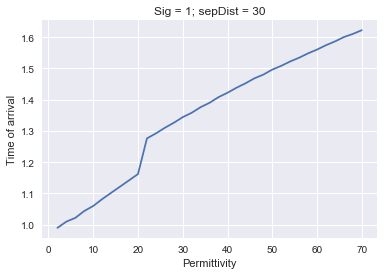

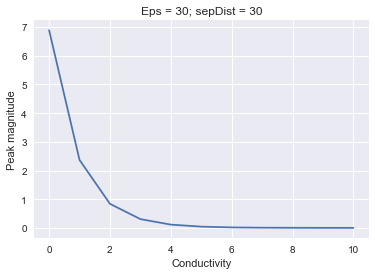

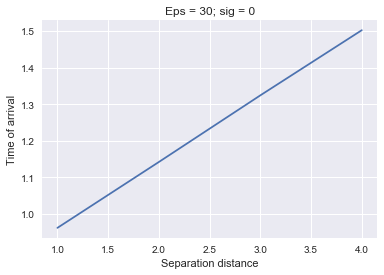

In [45]:
X_filt, y_filt = dp_ml.filterData(X_batch_max, y_batch_max, sig = 5, sepDist = 3)
plt.plot(y_filt[:,0], X_filt[:,2,1])
plt.title('Sig = 1; sepDist = 30')
plt.xlabel('Permittivity')
plt.ylabel('Time of arrival')

X_filt, y_filt = dp_ml.filterData(X_batch_max, y_batch_max, eps=30, sepDist = 3)
plt.figure()
plt.plot(y_filt[:,1], X_filt[:,2,0])
plt.title('Eps = 30; sepDist = 30')
plt.xlabel('Conductivity')
plt.ylabel('Peak magnitude')

plt.figure()
X_filt, y_filt = dp_ml.filterData(X_batch_max, y_batch_max, eps=30, sig = 0)
plt.plot(X_filt[:,0,0], X_filt[:,2,1])
plt.title('Eps = 30; sig = 0')
plt.xlabel('Separation distance')
plt.ylabel('Time of arrival')

### Interesting...

It looks like the pulse peak chose changes at about er=24 -- wonder if implementing first break would be better for this.

In [ ]:
X_batch_t, y_batch_t = dp_ml.getBatchFromDB(dbFile, dbHier, 0, numSim, freqOrTime='time', procFx = dp_ml.procIdentity)
X_batch_f, y_batch_f = dp_ml.getBatchFromDB(dbFile, dbHier, 0, numSim, freqOrTime='frequency', procFx = dp_ml.procIdentity)

## 3. Set up the learning method

### 3.1 Setting it up for getMax():

In [33]:
#init, saver, loss, training_op, X_ph, y, logits = dp_ml.set10pModel(n_inputs = 10,n_hidden1 =10,n_hidden2=3, batch_size=15, activation_function = tf.nn.sigmoid)
#init, saver, loss, training_op, X_ph, y, logits = dp_ml.setupModel(n_inputs = 10,n_hidden1 =30,n_hidden2=10, batch_size=100, activation_function = tf.nn.sigmoid)
init, saver, loss, training_op, X_ph, y, logits = dp_ml.setupModel(n_inputs = 6,
                        n_hidden1 =200,n_hidden2=100, batch_size=100, 
                        activation_function = tf.nn.relu,opt="adam",
                        learning_rate = 0.001)

## 4. Train the model

Benchmark so far is a loss of 0.05 for the getMax() -- this was without stochastic sample selection, using ReLU and Adam optimizer.

Trying using stochastic method now -- seems much better (down to 0.05 after only 50 epochs).
This is with [100,100] hidden layers, batch size 100, ReLU, Adam, learning rate 0.01.
Seems to be plateauing though -- might be worth trying this with different learning rate, different depth/breadth, etc.

In [34]:
dbFilename = '/Users/davidgarrett/Google Drive/Work/Software/machine_learning/postpro/dp_ml_07-Feb-2018.hdf5'
#dbFilename = 'C:/Users/dgarrett/Google Drive/Work/Software/machine_learning/postpro/dp_ml_07-Feb-2018.hdf5'


dbFolder = 'Data/Simulation/CircWG'
dp_ml.runModel(dbFilename, dbFolder, init, saver, loss, training_op, X_ph, y, procFx = dp_ml.getMax, freqOrTime = 'time',batch_size = 100, n_epochs = 200)

Model filename:  ./Models/ANN_model_20180214-140103_200-epochs_.ckpt
0 Train loss: 7.34913818359
1 Train loss: 4.46529052734
2 Train loss: 3.08322357178
3 Train loss: 2.42659454346
4 Train loss: 2.69552459717
5 Train loss: 1.89232299805
6 Train loss: 2.43883499146
7 Train loss: 1.83897064209
8 Train loss: 1.73313278198
9 Train loss: 1.96511932373
10 Train loss: 1.51023239136
11 Train loss: 1.60801315308
12 Train loss: 1.50543258667
13 Train loss: 1.66635513306
14 Train loss: 1.5517237854
15 Train loss: 1.41115600586
16 Train loss: 1.82396438599
17 Train loss: 1.32480895996
18 Train loss: 1.16449996948
19 Train loss: 1.29633285522
20 Train loss: 1.33826568604
21 Train loss: 1.21895484924
22 Train loss: 1.11547424316
23 Train loss: 1.03124778748
24 Train loss: 0.986265945435
25 Train loss: 0.955328521729
26 Train loss: 0.787923660278
27 Train loss: 0.755629425049
28 Train loss: 0.856090240479
29 Train loss: 0.894036941528
30 Train loss: 0.632464294434
31 Train loss: 0.819018249512
32 Tra

## 5. Predict from the model

In [44]:
model_name = './Models/ANN_model_20180214-122930_200-epochs_.ckpt'

ind = 1000
X_batch = X_batch_max[ind,:,:].reshape((1,6))
y_pred = dp_ml.predictFromModel(model_name, X_batch, saver, logits, X_ph)

print('True values:',y_batch_max[ind,0], y_batch_max[ind,1])
print('Predicted values:',y_pred[0,0], y_pred[0,1])



INFO:tensorflow:Restoring parameters from ./Models/ANN_model_20180214-122930_200-epochs_.ckpt
True values: 52.0 6.0
Predicted values: 50.2585 5.98598
